In [1]:
### Defining Environment variables pointing to user folders
from os import environ, path, makedirs
from json import load

environ.setdefault('HOME_DIR', "/mlinfn/shared/lamarr/"+ environ['USERNAME'])
environ.setdefault('TRAINING_DATA_FOLDER',"/j100")
environ.setdefault('MODEL_STORAGE'  ,environ['HOME_DIR']+"/trained_models"+environ['TRAINING_DATA_FOLDER'])
environ.setdefault('FEATHER_FOLDER' ,environ['HOME_DIR']+"/lb-trksim-train/notebooks/feather_folder"+environ['TRAINING_DATA_FOLDER'])
environ.setdefault("TRAIN_DATA"     ,environ['FEATHER_FOLDER']+"/resolution-train")
environ.setdefault("VALIDATION_DATA",environ['FEATHER_FOLDER']+"/resolution-validation")

environ.setdefault("MODEL_VARIANT","")
default_output_model = "/models/resolution/saved_model.pb"
if environ['MODEL_VARIANT'] != '':
    model_path,model_name = path.split(default_output_model)
    default_output_model = path.join(model_path,environ['MODEL_VARIANT'], model_name)
environ.setdefault('OUTPUT_MODEL',environ['MODEL_STORAGE']+default_output_model)

with open("Models_definitions.json") as mdl_file: # definition of variant models
    models_def = load(mdl_file)
    environ.setdefault('MODEL_DEFINITION',models_def['resolution'].get(environ['MODEL_VARIANT'],"ResolutionGAN(gen_layers=10,discr_layers=10,ref_layers=10,X_shape=X.shape,y_shape=y.shape)"))

_ = environ.setdefault('NB_EXPORT',"True") # whether export notebooks

In [2]:
%run construct_models.py # script containing models definitions

# Training Resolution model
##### Tested on kernel `TensorFow on GPU` as defined in the image `landerlini/lhcbaf:v0p8`

This notebook is part of a pipeline. It requires the preprocessing step defined in the 
[GAN preprocessing notebook](./Preprocessing-GANs.ipynb) and the trained model is 
validated in the [Resolution-validation](./Resolution-validation.ipynb) notebook.

### Environment and libraries
As for the other trainings, we are handling the GPU with TensorFlow.
To make sure the GPU is found, we print below the system name of the accelerator.

In [3]:
import numpy as np 
import pandas as pd 
import dask.dataframe as ddf
import os
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

print ("GPU:", tf.test.gpu_device_name())

/envs/root/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU: /device:GPU:0


## Loading the data

The data are loaded with our custom `FeatherReader` helper class, defined in the local module [`feather_io`](./feather_io.py).

In this notebook, we are using:
 * *training data*: to optimize the weights of the network
 * *validation data*: to evaluate overtraining effects

In [4]:
from feather_io import FeatherReader    

train_dataset = FeatherReader(environ.get("TRAIN_DATA", "resolution-train")).as_tf_dataset()
validation_dataset = FeatherReader(environ.get("VALIDATION_DATA", "resolution-validation")).as_tf_dataset()

A chunk of data is loaded to ease the construction of the model, for example defining the shapes of the input and output tensors.

In [5]:
X, y = next(iter(train_dataset.batch(1_000_000)))
y.shape

TensorShape([352184, 9])

## Definition of the model
The GANs used in this module are composed of three different neural networks trained simultaneously, namely:
 * a *generator* neural network that takes as an input the *condition* (such as the generator-level features) and the *random noise* and formulate predictions for the output
 * a *discriminator* neural network trained to identify whether a sample was part of the reference dataset or was produced by the generator
 * a *referee* network that mimics the configuration of the discriminator, is trained with a much larger learning rate.
 
Generator and discrminator are part of the architecture of GANs since [they were proposed in 2014](https://arxiv.org/abs/1406.2661),
with the underlying idea that the generator has to be trained to worsen the classification ability of the discriminator.
Generator and discriminator are players of a game in which they try to drive the classification loss function towards
higher and lower values, respectively. The outcome of the game that we wish to reach an equilibrium between 
the two players (Nash equilibrium) that forces both players to improve their abilities along the training 
and results into a generator providing samples with distributions almost indistinguishable from those of the 
reference sample.

Unfortunately, using the loss function of the discriminator as adversarial objective of two neural networks 
makes it harder to interpret it as metric for the goodness of the trained model.
A high value of the loss may be obtained with both an excellent generator evaluated by an excellent discriminator, 
or by an awful generator evaluated by an awful discriminator.
To evaluate the progress of the training and assess the overall quality of the generator, we introduced a third
neural network to the game that does not contribute to the training of the generator, but is a spectator providing 
and independent assessment of the agreement between the generated and the trained sample. We call this the *referee
network*. Since it does not provide a feedback to the generator, larger jumps in the parameter space do not cause
the training procedure of the generator to derail because of confusing information. Therefore, the learning rate can be larger.
A large learning rate is also useful to provide timely updates on the status of the network, identifying quickly 
the discrepancies between the generated and the reference sample.

The referee network was found to provide useful information when comparing the loss on the 
training and validation datasets. Indeed, we observed the ability of the *discriminator* 
to learn "by heart" some of the outlayers in the reference sample, resulting in a classification
that does not generalize to the validation dataset.

As for other tasks, we observed that L2 regularization is useful to contrast overtraining.
In addition, L2 regularization is expected to contrast sharp boundaries in the classification
function that may lead to explosions of the gradient when training the generator.

As discussed for the acceptance models, we adopted very deep neural networks with skip connections to 
achieve decent results with limited effort in hyperparameter optimization. This choice might be reviewed
with additional effort on tuning.

### Generator architecture
The generator takes the input conditions and the random noise as inputs and provides the target features as an output.
In formula,
$$
g: \mathbb R^{N_I} \otimes \mathbb R^{N_R} \to \mathbb R^{N_O} 
$$
where $N_I$ and $N_O$ respresent the number of input and output features, respectively; while $N_R$ is the 
dimension of the random noise

The activation function of the last layer is linear to avoid any constraint on the generated features.


In [6]:
generator,discriminator,referee = eval(environ["MODEL_DEFINITION"])

In [7]:
random = generator.inputs[1]
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 140)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          18048       ['concatenate[0][0]']        

### Discriminator
The generator takes as an input the conditions and the target features (either generated or from the reference sample) and provide the probability for the sample of being part of the reference sample.

In formula,
$$
d^{(th)}: \mathbb R^{N_I} \otimes \mathbb R^{N_O} \to [0, 1] \subset \mathbb R.
$$

Usually, to map the response of a neural network in the interval $[0, 1]$, the sigmoid function is used.
At implementation level, we decided to move the evaluation of the sigmoid from the activation of the last layer to the computation of the loss function.
This is believed to improve the numerical stability of the computation by avoiding taking the exponential of a logarithm.

In practice, our implemented discriminator will be described by
$$
d^{(impl)}: \mathbb R^{N_I} \otimes \mathbb R^{N_O} \to \mathbb R.
$$


In terms of implemntation, the tensor we are passing as an input to the neural network for each batch is composed as depicted
in the following table

<table width=300>
    <tr><th colspan=2>$X$<th><th>$y$</tr>
    <tr><td>Input conditions (gen. level features)<td><b>Reference</b> target features<td><td><b>1</b></tr>
    <tr><td>Input conditions (gen. level features)<td><b>Generated</b> target features<td><td><b>0</b></tr>
</table>

The input conditions are repeated twice, but in the first half of the batch 
they are completed with the output features of the reference samples and labeld as $1$.
In the second half of the batch they are completed with randomly generated features and labeld with $0$.


In [8]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 12)           0           ['input_3[0][0]',                
                                                                  'input_3[0][0]']          

### Referee network
The referee network mimics the discriminator network, therefore
$$
r: \mathbb R^{N_I} \otimes \mathbb R^{N_O} \to \mathbb R
$$
The input tensor is built in the same way as for the discriminator.

In [9]:
referee.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 12)           0           ['input_6[0][0]',                
                                                                  'input_6[0][0]']          

### Training step

The training step is defined with the lower-level tensorflow API because we need to carefully
tune which weights we wish to update based on each evaluation of a loss function.

Technically, we are using the tensorflow [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) 
to keep track of the gradient while we describe the computation of the loss function.
We will have a different tape for each neural network, recording the derivatives of the 
loss functions with respect to the weights of that particular network.

#### Notes on the chosen loss function
The loss function for the classification task is clearly a Binary Cross Entropy (BCE).
However we adopt two non-default options for its computation:
 * `from_logit=True`, to improve the numerical stability of the gradient computation, which
   is of particular importance for GANs because of the very long training procedure that 
   may inflate the errors due to many subsequent iterations
 * `label_smoothing=0.1`, to introduce a penalty against overconfident classification, which 
   corresponds to the *plateaux* of the sigmoid function, where the gradient is null, providing
   no useful information for the generator's training.


In [10]:
compute_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
g_optimizer = tf.keras.optimizers.Adam(1e-4)
d_optimizer = tf.keras.optimizers.Adam(1e-4)
r_optimizer = tf.keras.optimizers.Adam(5e-4)

@tf.function
def train_step(dataset):
    # Unpack the dataset to retrieve input and output
    X, y_ref = dataset
    
    # Compute the batch size
    batch_size = tf.shape(X)[0]
    
    # Prepares the tensor of labels for the discriminator, based on the batch_size
    label_true = tf.concat((tf.ones(batch_size), tf.zeros(batch_size)), axis=0)

    # Generate the random noise. Once per batch.
    r = tf.random.normal([batch_size, random.shape[1]], 0., 1.)
    
    # Begins the computation of the loss, tracking the gradient
    with tf.GradientTape(watch_accessed_variables=False) as tape_generator:
        with tf.GradientTape(watch_accessed_variables=False) as tape_discriminator:
            # The gradient will be computed with respect to the variables defined here
            tape_generator.watch(generator.weights)
            tape_discriminator.watch(discriminator.weights)
            
            # Run the generator
            y_gen = generator((X, r))

            # Run the discriminator and obtain the logits
            label_pred = discriminator((X, y_ref, y_gen))
            
            # Convert the logits into a loss function
            d_loss = compute_loss(label_true, label_pred)
            
            # Invert the loss function of the discriminator to obtain the loss 
            # of the generator
            g_loss = -d_loss
            
    # Begins the computation of the loss of the referee network
    # Note that it is completely indepenent of the generator training
    with tf.GradientTape() as tape_referee:
        # Defines the variables
        tape_referee.watch(referee.weights)
        # Runs the referee discriminator
        label_referee = referee((X, y_ref, y_gen))
        # Compute the loss of the referee network
        r_loss = compute_loss(label_true, label_referee)

    # Compute the gradients of the loss of each NN wrt. to its weights
    g_vars = generator.weights
    d_vars = discriminator.weights
    r_vars = referee.weights
    
    d_grads = tape_discriminator.gradient(d_loss, d_vars)
    g_grads = tape_generator.gradient(g_loss, g_vars)
    r_grads = tape_referee.gradient(r_loss, r_vars)
    
    ## Apply the gradients
    g_optimizer.apply_gradients(zip(g_grads, g_vars))
    d_optimizer.apply_gradients(zip(d_grads, d_vars))
    r_optimizer.apply_gradients(zip(r_grads, r_vars))
    
    ## Return the value of the loss for monitoring purpose
    return r_loss

    

@tf.function
def test_step(dataset):
    X, y_ref = dataset
    batch_size = tf.shape(X)[0]
    r = tf.random.normal([batch_size, random.shape[1]], 0., 1.)
    
    y_gen = generator((X, r))

    label_pred = referee((X, y_ref, y_gen))
    label_true = tf.concat((tf.ones(batch_size), tf.zeros(batch_size)), axis=0)

    return compute_loss(label_true, label_pred)
    

## Training

 * Batch size: 1k
 * Number of epochs: 1000

In [11]:
from tqdm import trange, tqdm

losses = []
validation_loss = []

vdst = next(iter(validation_dataset.batch(100_000)))

progress_bar = trange(1000)

for epoch in progress_bar:
    epoch_losses = []
    for dset in train_dataset.batch(1000):
        epoch_losses.append(train_step(dset))
    losses.append(np.mean(epoch_losses))
    validation_loss.append(test_step(vdst).numpy())
    
    progress_bar.set_description(f"Training (validation) loss: {losses[-1]:.3f} ({validation_loss[-1]:.3f})")

Training (validation) loss: 0.280 (0.298):   3%|▎         | 28/1000 [01:06<38:34,  2.38s/it] 


KeyboardInterrupt: 

The evolution of the loss function as evaluated by the referee network is reported below.
A dashed line represent the ideal value of the BCE when evaluated on two identical datasets with an ideal classifier.

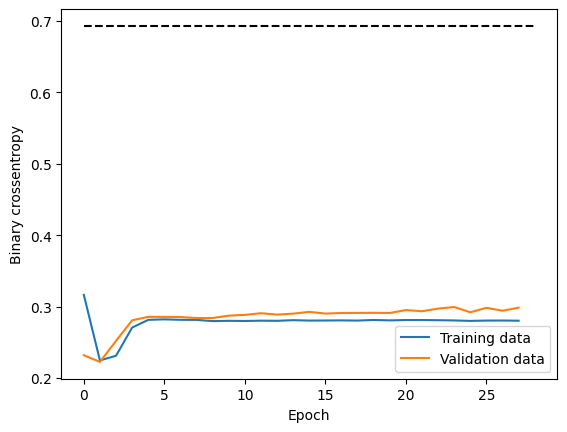

In [13]:
history = {
    "loss":losses,
    "val_loss":validation_loss
}

import matplotlib.pyplot as plt
plt.plot(losses, label="Training data")
plt.plot(validation_loss, label="Validation data")
plt.plot([0, len(losses)], [np.log(2)]*2, 'k--')

plt.xlabel("Epoch")


plt.ylabel("Binary crossentropy")
plt.legend()
plt.show()

## Exporting the model
The model is exported to the same directory were the preprocessing steps `tX` and `tY` were stored.

In [19]:
from models_utils import GetModelProperties,MakeMD
from json import dump

base_dir = path.dirname(environ['OUTPUT_MODEL'])
makedirs(base_dir,exist_ok=True)
generator.save(base_dir)

# save model and training information
jsonfile = "model_info.json"
info_path = path.join(base_dir, jsonfile)
props = GetModelProperties(generator,history=str(history),optimizer=g_optimizer)

with open(info_path,'w') as json_file:
    dump(props,json_file)

# write model description in MD file
MakeMD(props,mdfile=path.join(base_dir, "model_info.md"))

INFO:tensorflow:Assets written to: /mlinfn/shared/lamarr/scapelli/trained_models/j100/models/resolution/assets


## Conclusion
In this notebook we discussed the training procedure of the GAN model used to parametrize the resolution.

In particular, we discussed
 * the overall structure of the DNN system;
 * the architecture of the generator, discriminator and of a referee network we introduced to ease monitoring, debugging an hyperparameter optimization
 * the procedure for optimizing the weights of the three networks based on three different computations of the gradients
 * the outcome of the training procedure as visualized by the evolution of the loss of the referee network

Finally, we exported the model for deployment and further validation.


In [ ]:
### export notebooks for comparisons
if environ.get('NB_EXPORT',"False")=="True":
    from os import system,makedirs
    
    nb_save  = f"{environ['HOME_DIR']}/notebooks_exports"  # export output dir
    nb_save  = nb_save+environ['TRAINING_DATA_FOLDER']     # according to train data
    if environ['MODEL_VARIANT'] != '':
        nb_save  = nb_save+'/'+environ['MODEL_VARIANT']    # according to model variant
    makedirs(nb_save,exist_ok=True)                       
    
    nbs_path = f"{environ['HOME_DIR']}/lb-trksim-train/notebooks" # notebooks folder
    nb_filename = "Resolution.ipynb"                              # notebook name
    extensions  = ["html"]                                  # export formats
    for ext in extensions:
        system("jupyter nbconvert --log-level=40 --no-input --output-dir {0} --to {1} {2}/{3}".format(nb_save,ext.upper(),nbs_path,nb_filename))
    print("Exported {} as {} in {}".format(nb_filename,','.join(extensions),nb_save))